In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
%cd /content/gdrive/My Drive/Colab\ Notebooks/Neural\ style\ transfer

/content/gdrive/My Drive/Colab Notebooks/Neural style transfer


In [11]:
!ls

content      styles		 style_transfer2.py	 style_transfer3.py
__pycache__  style_transfer1.py  style_transfer_3.ipynb


In [0]:
from __future__ import print_function, division
from builtins import range, input

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from style_transfer1 import VGG16_AvgPool, VGG16_AvgPool_CutOff, unpreprocess, scale_img
from style_transfer2 import gram_matrix, style_loss, minimize
from scipy.optimize import fmin_l_bfgs_b

In [0]:
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

In [0]:
content_img = load_img_and_preprocess(
    # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
    # 'batman.jpg',
    'content/sydney.jpg',
    # (225, 300),
)

In [0]:
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  'styles/starrynight.jpg',
  (h, w)
)

In [0]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [17]:
vgg = VGG16_AvgPool(shape)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
content_model = Model(vgg.input, vgg.layers[13].get_output_at(-1))
content_target = K.variable(content_model.predict(content_img))

In [0]:
symbolic_conv_outputs = [
  layer.get_output_at(-1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

In [0]:
style_model = Model(vgg.input, symbolic_conv_outputs)

In [0]:
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

In [0]:
style_weights = [0.2,0.4,0.3,0.5,0.2]

In [0]:
loss = K.mean(K.square(content_model.output - content_target))

In [0]:
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

In [0]:
grads = K.gradients(loss, vgg.input)

In [0]:
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

In [0]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=2500.440673828125
iter=1, loss=323.0518798828125
iter=2, loss=184.96730041503906
iter=3, loss=144.87054443359375
iter=4, loss=122.23011016845703
iter=5, loss=107.58016204833984
iter=6, loss=96.9180908203125
iter=7, loss=88.51437377929688
iter=8, loss=82.78323364257812
iter=9, loss=78.3849105834961
duration: 0:00:39.270200


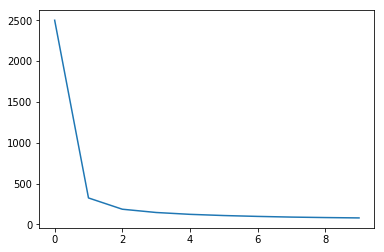

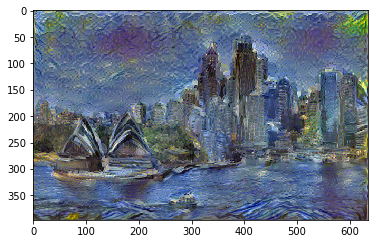

In [31]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()